In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/ProcessedPR.csv')

In [4]:
data.head()

,Unnamed: 0,Date,Member,Party,State / District,Title,Press Release,sentences,docTokens
0,0,May 12,Ayanna Pressley,D,Mass.-7,"WATCH: In Powerful Mothers Day Speech, Pressle...","May 12, 2024 “Mr. Speaker, mothers across Amer...","['may mr', 'speaker mother across america want...",may mr speaker mother across america want hall...
1,1,May 10,Adrian Smith,R,Neb.-3,Pushing Back on Unworkable Executive Mandates,"502 Cannon HOB, Washington, DC 20515Email Me(2...",['cannon hob washington dc president obama fam...,cannon hob washington dc president obama famou...
2,2,May 9,Robert E. Latta,R,Ohio-5,Latta's Op-Ed: EPAs new power plant rule is ne...,Congressman Bob Latta (R-OH5) penned an op-ed ...,['congressman bob latta penned washington exam...,congressman bob latta penned washington examin...
3,3,May 10,Morgan Griffith,R,Va.-9,Congressman Griffiths Weekly E-Newsletter 5.10.24,It has been roughly four and a half years sinc...,['roughly four half year since start pandemic ...,roughly four half year since start pandemic de...
4,4,May 3,Steve Cohen,D,Tenn.-9,Celebrating the Grand Opening of the Orange Mo...,"May 3, 2024 Dear Friend, Last Friday, I atte...",['may dear friend last friday attended grand o...,may dear friend last friday attended grand ope...


In [5]:
data['docTokens'].isna().value_counts()

docTokens
False    985
True       4
Name: count, dtype: int64

In [6]:
import pandas as pd
data = data.dropna(subset=['docTokens'])

## TD-IDF - based on full documents

In [7]:
from sklearn.model_selection import train_test_split

X_train, x_val, y_train, y_val = train_test_split(data['docTokens'], data['Party'], test_size=0.2, stratify=data['Party'])
print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(x_val)}')

Training samples: 788
Validation samples: 197


In [8]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_val_ohe = ohe.transform(y_val.values.reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')

One hot encoded training labels shape: (788, 2)
One hot encoded validation labels shape: (197, 2)


In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_val_le = label_encoder.transform(y_val)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_val_le.shape}')

Label encoded training labels shape: (788,)
Label encoded validation labels shape: (197,)


In [10]:
for i in range(5):
    print(f'Original label: {y_train.iloc[i]} - Label encoded: {y_train_le[i]}')

Original label: D - Label encoded: 0
Original label: D - Label encoded: 0
Original label: D - Label encoded: 0
Original label: D - Label encoded: 0
Original label: R - Label encoded: 1


In [11]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [12]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(kernel='linear', C=1.0, random_state=42))
])

# fit the model
text_clf.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(kernel='linear', random_state=42))])

In [13]:
text_clf.score(x_val, y_val_le)

0.883248730964467

## RNN on full data based on documents

In [14]:
import random

# sample a random sentence from the training set
random_idx = random.randint(0, len(X_train))
print(f'Random Document: {X_train.iloc[random_idx]}')
print(f'Party: {y_train.iloc[random_idx]}')

Random Document: follows senator markey letter david malpass former world bank president letter text pdf washington april senator edward markey chair senate environment public work subcommittee clean air climate nuclear safety today led letter senator sheldon whitehouse martin heinrich world bank president ajay banga urging world bank stop fossil fuel financing increase climate investment step senator markey colleague initially called last february letter also asks world bank increase transparency financing decision engage meaningfully developing country activity relevant loss damage temporarily housed world bank world bank spring meeting begin world bank still publicly committed ending fossil fuel financing risk fueling climate crisis reducing available capacity bank support developing country clean development adaptation effort letter world bank member wrote world bank committed align financial flow goal paris agreement climate change action plan bank provided average billion annuall

In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_val_ohe = ohe.transform(y_val.values.reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')

One hot encoded training labels shape: (788, 2)
One hot encoded validation labels shape: (197, 2)


In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Create a TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=8000,  # Maximum size of the vocabulary
    output_mode='int',          # Output the token indices as integers
    output_sequence_length=600,  # Length of output sequences
    pad_to_max_tokens=True      # Pad sequences to max_tokens
)

In [17]:
import random

text_vectorizer.adapt(X_train.values)

example_sent = random.choice(X_train.values)
print(f'Original text:\n{example_sent}')
print(f'\nVectorized text:\n{text_vectorizer([example_sent])}')
print('Length of vector:', len(text_vectorizer([example_sent]).numpy()[0]))

Original text:
washington arizona congressman greg stanton juan ciscomani introduced data secured border act bipartisan legislation improve communication within department homeland security provide congress data better inform secure southern border decision maker need see whole real time bill break bureaucratic silo give law enforcement frontlines information need job stanton said order effectively address issue southern border must proper information knowledge improving collection reporting metric congress cbp local authority able work efficiently find proper solution secure border ciscomani said bill would require dhs submit report congress usefulness congressionally mandated border security metric evaluate work done department joint requirement council bill would also require dhs make recommendation updating border security metric address jrc assist dhs disrupting flow fentanyl addressing backlog migrant processing incorporating technological advance border management one page summa

In [18]:
vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocabulary: {len(vocab)}')
print(f'Most common words in the vocabulary: {vocab[:5]}')
print(f'Least common words in the vocabulary: {vocab[-5:]}')

Number of words in the vocabulary: 8000
Most common words in the vocabulary: ['', '[UNK]', 'senator', 'act', 'said']
Least common words in the vocabulary: ['repercussion', 'repaving', 'repaired', 'repaid', 'reorganization']


In [19]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 8000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 600,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 8000}

In [20]:
token_embedding = tf.keras.layers.Embedding(input_dim=len(vocab),
                                            output_dim=128,
                                            mask_zero=True,
                                            name='token_embedding')

print(f'Sentence before vectorization: {example_sent}')
vectorized_sent = text_vectorizer(example_sent)
print(f'Sentence after vectorization: {vectorized_sent}')
embedded_sent = token_embedding(vectorized_sent)
print(f'Sentence after embedding: {embedded_sent}')

Sentence before vectorization: washington arizona congressman greg stanton juan ciscomani introduced data secured border act bipartisan legislation improve communication within department homeland security provide congress data better inform secure southern border decision maker need see whole real time bill break bureaucratic silo give law enforcement frontlines information need job stanton said order effectively address issue southern border must proper information knowledge improving collection reporting metric congress cbp local authority able work efficiently find proper solution secure border ciscomani said bill would require dhs submit report congress usefulness congressionally mandated border security metric evaluate work done department joint requirement council bill would also require dhs make recommendation updating border security metric address jrc assist dhs disrupting flow fentanyl addressing backlog migrant processing incorporating technological advance border managemen

In [21]:
X_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train_ohe))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val.values, y_val_ohe))

In [22]:

BATCH_SIZE = 15

In [23]:
train_dataset = X_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [24]:
# MODEL Hyperparameters
learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
loss = 'categorical_crossentropy'
epochs = 20

In [25]:
# Model architecture

from tensorflow.keras import layers, regularizers

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)

x = token_embedding(x)
x = tf.keras.layers.Flatten()(x)


outputs = layers.Dense(num_classes, activation='softmax')(x)

party_model = tf.keras.Model(inputs, outputs)

party_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'party_model'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [27]:
history = party_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[model_checkpoint_callback])

Epoch 1/20
52/53 [============================>.] - ETA: 0s - loss: 0.6968 - accuracy: 0.5231
Epoch 1: val_accuracy improved from -inf to 0.49746, saving model to party_model
53/53 [==============================] - 6s 92ms/step - loss: 0.6968 - accuracy: 0.5228 - val_loss: 0.6916 - val_accuracy: 0.4975
Epoch 2/20
51/53 [===========================>..] - ETA: 0s - loss: 0.6409 - accuracy: 0.6536
Epoch 2: val_accuracy improved from 0.49746 to 0.50254, saving model to party_model
53/53 [==============================] - 2s 44ms/step - loss: 0.6414 - accuracy: 0.6510 - val_loss: 0.6853 - val_accuracy: 0.5025
Epoch 3/20
51/53 [===========================>..] - ETA: 0s - loss: 0.5987 - accuracy: 0.7412
Epoch 3: val_accuracy improved from 0.50254 to 0.55330, saving model to party_model
53/53 [==============================] - 2s 45ms/step - loss: 0.5988 - accuracy: 0.7437 - val_loss: 0.6786 - val_accuracy: 0.5533
Epoch 4/20
51/53 [===========================>..] - ETA: 0s - loss: 0.5562 - ac

In [31]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

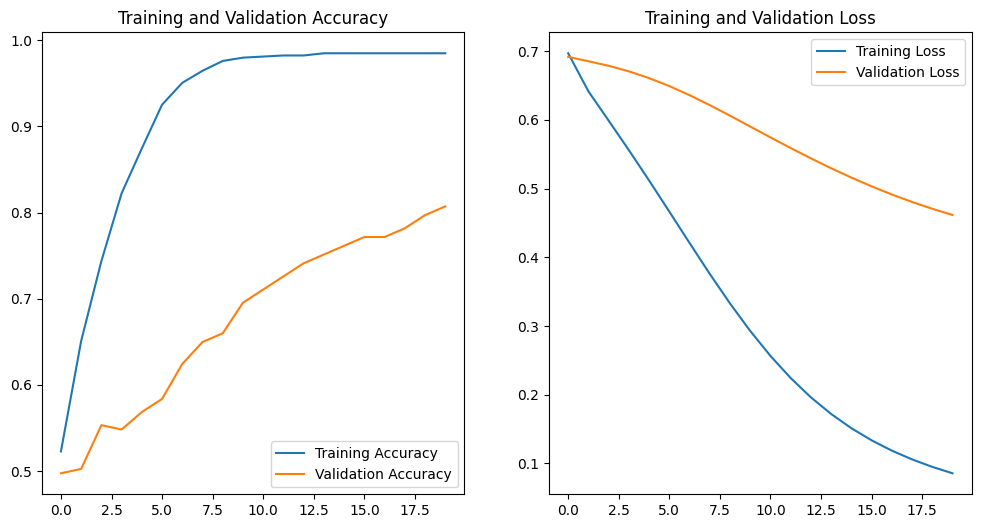

In [32]:
plot_history(history)

In [33]:
import pickle

model_path = "/content/drive/My Drive/Colab Notebooks/party_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(party_model, f)